In [2]:
import numpy as np
import os
import sys
sys.path.append(r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
import matplotlib.pyplot as plt # for plotting
%matplotlib widget
import seaborn as sns # for plotting
import pandas as pd # for data manipulation
from Models.load_data import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Load the shot data and replace nans with zeros to get arrays of equal length
path = r'C:\Users\Max Tost\Desktop\Notebooks\SPC Neural Network Project\Training_data'
features_list = os.listdir(os.path.join(path, r'features'))

# Replace 'path' and 'features_list' with your actual base path and list of feature file names.
X, y = load_all_data(path, features_list)

print("Combined features shape:", X.shape)
print("Combined targets shape:", y.shape)

Key ECE_PF not in JETno100176.csv. Filling it with zeros.
Key RNT not in JETno100184.csv. Filling it with zeros.
Key ECE_PF not in JETno100198.csv. Filling it with zeros.
Key RNT not in JETno100228.csv. Filling it with zeros.
Key ECE_PF not in JETno100535.csv. Filling it with zeros.
Key DAI_EDG7 not in JETno80609.csv. Filling it with zeros.
Key DAI_EDG7 not in JETno80848.csv. Filling it with zeros.
Key DAI_EDG7 not in JETno80853.csv. Filling it with zeros.
Key DAI_EDG7 not in JETno81187.csv. Filling it with zeros.
Key DAI_EDG7 not in JETno81568.csv. Filling it with zeros.
Key DAI_EDG7 not in JETno81586.csv. Filling it with zeros.
Key ECE_PF not in JETno81929.csv. Filling it with zeros.
Key DAI_EDG7 not in JETno82017.csv. Filling it with zeros.
Key DAI_EDG7 not in JETno82257.csv. Filling it with zeros.
Key DAI_EDG7 not in JETno82466.csv. Filling it with zeros.
Key ECE_PF not in JETno82811.csv. Filling it with zeros.
Key DAI_EDG7 not in JETno82826.csv. Filling it with zeros.
Key DAI_EDG7

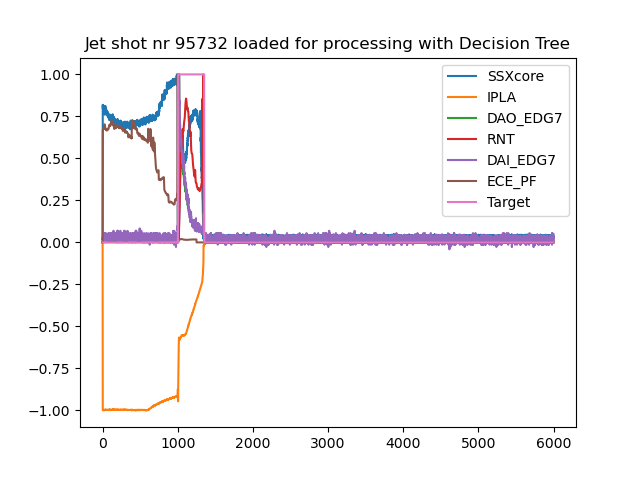

In [4]:
RE_valid = [91076, 95732, 95768, 97081, 97085, 97086, 98088, 98150, 98169, 98173, 98176]
shot_re = RE_valid[1]
shot_re_id = features_list.index('JETno' + str(shot_re) + '.csv')
# Validation that data conversion worked: positive
features_sequence = ['SSXcore', 'IPLA', 'DAO_EDG7', 'RNT', 'DAI_EDG7', 'ECE_PF']
x_re = X[6000*shot_re_id:6000*(shot_re_id+1):, :].T
y_re = y[6000*shot_re_id:6000*(shot_re_id+1):]
plt.close()
for x, label in zip(x_re, features_sequence):
    plt.plot(x/max(np.absolute(x)), label = label)
plt.plot(y_re.T, label='Target')
plt.title(f'Jet shot nr {shot_re} loaded for processing with Decision Tree')
plt.legend()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
features_sequence = ['SSXcore', 'IPLA', 'DAO_EDG7', 'RNT', 'DAI_EDG7', 'ECE_PF']

data = pd.DataFrame(X, columns=features_sequence)
data['label']=y
data['label'] = data['label'].map({0: 'No RE', 1: 'RE'})

In [5]:
from imblearn.over_sampling import SMOTE

# Instantiate SMOTE with a fixed random_state for reproducibility
smote = SMOTE(random_state=42)

# Apply SMOTE only on the training data
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [6]:
print('Before resampling the minority class, counts of appearences of 1 and 0 respectively')
print(len(np.where(y_train==1)[0]), len(np.where(y_train==0)[0]))
print('After oversampling the minority class')
print(len(np.where(y_train_res==1)[0]), len(np.where(y_train_res==0)[0]))

Before resampling the minority class, counts of appearences of 1 and 0 respectively
19432 1420571
After oversampling the minority class
1420571 1420571


In [89]:
# Convert the data into DMatrix
dtrain = xgb.DMatrix(X_train_res, label=y_train_res)
dtest = xgb.DMatrix(X_test, label=y_test)

In [106]:
# Set parameters for binary classification
#{'eta': 0.12952757908461118, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.9136547225140513, 'colsample_bytree': 0.7982666062021071, 'scale_pos_weight': 1.139133758423292}
params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "eta": 0.12952757908461118,
        "max_depth": 10,
        "min_child_weight": 1,
        "subsample": 0.9136547225140513,
        "colsample_bytree": 0.7982666062021071,
        "scale_pos_weight": 1.139133758423292
    }

In [107]:
num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)

In [108]:
# Predict on the train set
y_pred = bst.predict(dtrain)

# Convert probabilities to binary labels (assuming binary classification)
y_pred_labels = (y_pred > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_train_res, y_pred_labels)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 1.00


In [109]:
# Predict on the test set
y_pred = bst.predict(dtest)

# Convert probabilities to binary labels (assuming binary classification)
y_pred_labels = (y_pred > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_labels)
print(f"Accuracy: {accuracy:.2f}")
#

Accuracy: 1.00


In [110]:
from sklearn.metrics import classification_report

# Assuming you have predictions from your model
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    355047
         1.0       0.77      0.98      0.86      4954

    accuracy                           1.00    360001
   macro avg       0.88      0.99      0.93    360001
weighted avg       1.00      1.00      1.00    360001



In [65]:
0.5.astype(int)

AttributeError: 'float' object has no attribute 'astype'

## Parameter Optimization

In [103]:
import optuna
import xgboost as xgb

# Assume X_train_res and y_train_res are your training data.
dtrain = xgb.DMatrix(X_train_res, label=y_train_res)

def objective(trial):
    # Define the hyperparameter search space
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "eta": trial.suggest_loguniform("eta", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
        "scale_pos_weight": trial.suggest_uniform("scale_pos_weight", 0.5, 1.5)
    }
    
    # Use cross-validation to evaluate the model
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=1000,       # Set a high number; early stopping will determine the optimal round
        nfold=3,                    # 3-fold cross-validation
        metrics="logloss",
        early_stopping_rounds=10,   # Stop if no improvement after 10 rounds
        seed=42,
        verbose_eval=False
    )
    
    # Extract the best score (lower logloss is better)
    best_logloss = cv_results["test-logloss-mean"].min()
    return best_logloss

In [104]:
# Create a study object specifying that we want to minimize the logloss.
study = optuna.create_study(direction="minimize")

# Optimize the objective function over 100 trials (adjust n_trials as needed)
study.optimize(objective, n_trials=100)

# Output the best hyperparameters found
print("Best trial:")
print("  Value (logloss):", study.best_trial.value)
print("  Params:", study.best_trial.params)

[I 2025-02-06 11:48:55,764] A new study created in memory with name: no-name-222d1875-62b2-4563-b757-0e4c708ed7fd
C:\Users\Max Tost\AppData\Local\Temp\ipykernel_6564\3964031039.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "eta": trial.suggest_loguniform("eta", 0.01, 0.3),
C:\Users\Max Tost\AppData\Local\Temp\ipykernel_6564\3964031039.py:15: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
C:\Users\Max Tost\AppData\Local\Temp\ipykernel_6564\3964031039.py:16: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugges

KeyboardInterrupt: 